In [407]:
from src.utils.data_utils import str_dict_to_values
from src.utils.results_utils import *
from src.utils.ml_utils import *

import plotly.colors as pco
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
from scipy.stats import chi2_contingency
import nbformat
import os

# 0. Loading the cleaned dataset

In [317]:
df_char_cleaned = pd.read_csv('data/cleaned.csv')

df_char_cleaned['Languages'] = df_char_cleaned['Languages'].apply(str_dict_to_values)
df_char_cleaned['Country'] = df_char_cleaned['Country'].apply(str_dict_to_values)

# 1. Presenting the Data
## 1.a. General 

The cleaned dataset looks like this : 

In [318]:
# Create a copy of the original DataFrame to rename columns
df_char_cleaned_column = df_char_cleaned.copy()

# Rename columns to be clearer
df_char_cleaned_column.columns = [
    'Wikipedia ID', 'Movie Name', 'Languages', 'Production Country', 
    'Movie Genre', 'Character Name', 'Gender', 'Actor Age', 'Release Date'
]

# Display a random sample of 5 rows from the new DataFrame
df_char_cleaned_column.sample(5)

,Wikipedia ID,Movie Name,Languages,Production Country,Movie Genre,Character Name,Gender,Actor Age,Release Date
5512,24158189,Winter People,[English Language],[United States of America],William,M,76.0,1989-04-14,"['Romance', 'Drama', 'Historical & War']"
148673,16258940,Aaja Nachle,[Hindi Language],[India],Dia,F,40.0,2007-11-30,"['Comedy', 'Music & Performance', 'Drama', 'Ro..."
37569,158982,You've Got Mail,[English Language],[United States of America],Kevin,M,25.0,1998-12-18,"['Comedy', 'Romance']"
115397,27285282,The People I've Slept With,[English Language],"[United States of America, Hong Kong, Canada]",Ron,M,NaN,2010-08-13,"['Comedy', 'Cult & B-Movies', 'Romance']"
24989,35647254,Alyah,[French Language],[France],Esther,F,NaN,2012-05-18,['Drama']


In [319]:
# Calculer le nombre de valeurs non nulles par colonne
value_count_per_column = df_char_cleaned.notnull().sum()

# Définir les données du graphique
data = go.Bar(
    x=df_char_cleaned.columns,
    y=value_count_per_column.values,
    marker=dict(
        color='#A9D6C3'  # Utiliser une couleur vert clair
    ),
    text=[f"Count: {count}" for count in value_count_per_column.values],
    hoverinfo='text',
    textposition='none'
)

# Créer la mise en page
layout = go.Layout(
    title='Number of Values in Each Category of the Cleaned Dataset',
    xaxis=dict(title='Dataset Columns'),
    yaxis=dict(title='Number of Values'),
    barmode='group'
)

# Créer et afficher le graphique
fig = go.Figure(data=[data], layout=layout)
fig.show()


We observe that the dataset contains 160,432 entries. Some values are missing in the columns Gender, Actor Age, and Release Date.

In [320]:
total_count = len(df_char_cleaned['Character_name'])
name_count = df_char_cleaned['Character_name'].nunique()
movie_count = df_char_cleaned['Wikipedia_ID'].nunique()

summary_df = pd.DataFrame({
    'Category': ['Total Character Names','Unique Character Names', 'Unique Movies'],
    'Count': [total_count, name_count, movie_count]
})

summary_df.head()

,Category,Count
0,Total Character Names,159691
1,Unique Character Names,37883
2,Unique Movies,31072


In [321]:
plot_sex_distribution_with_top_names(df_char_cleaned)

In [322]:
# Create a df with the name count per gender
df_count_gender = df_char_cleaned.groupby('Sex')['Character_name'].count()

# Create a df that show the distribution 
summary_df = pd.DataFrame({
    'Gender': df_count_gender.index,
    'Distribution (%)': df_count_gender.values/value_count_per_column['Sex']*100
})

summary_df.head()

,Gender,Distribution (%)
0,F,36.770114
1,M,63.229886


The dataset shows a slight imbalance between genders, with about half as many female entries as male. However, since there is still a substantial amount of data, this imbalance is unlikely to significantly impact the results. 

Additionally, according to a 2022 study by the Center for the Study of Women in Television and Film at San Diego State University, 34 % of leading characters in the top 100 popular films were women, compared to 66 % men. This supports the dataset's gender distribution as representative of broader industry trends.

In [323]:
# Creating the top 1000 most popular character names set
name_counts = df_char_cleaned['Character_name'].value_counts()
top_100_names = name_counts.head(1000)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=top_100_names.index,
    y=top_100_names.values,
    mode='lines+markers',
    name='Character Count',
    line=dict(color='#A9D6C3'),
    hovertext=[f"Name: {name}<br>Count: {count}" for name, count in zip(top_100_names.index, top_100_names.values)],
    hoverinfo="text",
    marker=dict(
        color='#A9D6C3'  # Utiliser une couleur vert clair
    )
))

fig.update_layout(
    title='1000 Most Popular Character Names',
    xaxis_title='Character Name',
    yaxis_title='Count',
    xaxis=dict(showticklabels=False)
)

fig.show()

We can clearly see that John is the most popular name given to characters, with 1305 appartitions. One possible explanation is that John Doe was used in North America to refer to “any man whose name is unknown”. This could explain its appearance in this many movies, far ahead of the second most common name, Georges, with 621 appearances.

In [324]:
# df_char_cleaned.head()
df_char_cleaned_SA = df_char_cleaned.copy()
df_char_cleaned_SA.head()

,Wikipedia_ID,Name,Languages,Country,Character_name,Sex,Actor_age,Release_date,Genre_Category
0,975900,Ghosts of Mars,[English Language],[United States of America],Akooshay,F,42.0,2001-08-24,"['Action & Adventure', 'Horror & Thriller', 'F..."
1,975900,Ghosts of Mars,[English Language],[United States of America],Melanie,F,27.0,2001-08-24,"['Action & Adventure', 'Horror & Thriller', 'F..."
2,975900,Ghosts of Mars,[English Language],[United States of America],Williams,M,32.0,2001-08-24,"['Action & Adventure', 'Horror & Thriller', 'F..."
3,975900,Ghosts of Mars,[English Language],[United States of America],Jericho,M,33.0,2001-08-24,"['Action & Adventure', 'Horror & Thriller', 'F..."
4,975900,Ghosts of Mars,[English Language],[United States of America],Bashira,F,23.0,2001-08-24,"['Action & Adventure', 'Horror & Thriller', 'F..."


## 1.b. Research Questions

faire une partie ou on pose nos research questions avec quelques plots qui nous poussent à se poser ces questions là

In this study, we aim to explore the factors that influence the naming of characters in movies and uncover potential patterns. Names often carry meaning, cultural significance, and symbolic associations, making them an integral part of storytelling. By analyzing character names, we seek to determine whether they are assigned randomly or if they reflect specific traits such as gender, age, origin, or moral alignment **(est ce qu'on met movie genre ?)**. Additionally, we will investigate how naming conventions differ across contexts, with a particular focus on comparing movie productions from the United States during the Cold War. In this context, we hope to uncover strong correlations between the portrayal of "good guys" and "bad guys," particularly in how Soviet characters were named and depicted in contrast to American characters. This analysis aims to reveal how ideological narratives and cultural biases influenced character naming during this period.  

Our research is guided by the following questions:

- Is there a correlation between a character's name and their **gender**?  
- Can we observe a relationship between a character's name and their **age**?  
- How does a character's **origin** influence their name?  
- Are character names linked to the **movie genre** they appear in?  
- Is there a pattern in character names that distinguishes **good characters** from **villains**?  

- Are specific name characteristics (e.g., **length**, **syllables**, or **cultural roots**) consistently associated with certain **character features**?  

- How do naming conventions in U.S. movie productions during the Cold War reflect ideological narratives, particularly in the portrayal of Soviet characters as "good guys" or "bad guys"?  

# 2. Identifying Patterns: Origins of the Hypothesis

Intro à écrire sur le Name Feature processor, les features qu'on a decidé d'utiliser etc

In [325]:
# Extracting the name's characteristics 
processor = NameFeatureProcessor('Name',ngram_range=(2, 3))
character_names_processed = processor.process(df_char_cleaned)

In [326]:
character_names_processed.head()

,Wikipedia_ID,Name,Languages,Country,Character_name,Sex,Actor_age,Release_date,Genre_Category,Length,...,ž_l,â_l,Í_l,È_l,ō_l,î_l,ñ_l,ó_l,Õ_l,ò_l
0,975900,Ghosts of Mars,[English Language],[United States of America],Akooshay,F,42.0,2001-08-24,"['Action & Adventure', 'Horror & Thriller', 'F...",14.0,...,0,0,0,0,0,0,0,0,0,0
1,975900,Ghosts of Mars,[English Language],[United States of America],Melanie,F,27.0,2001-08-24,"['Action & Adventure', 'Horror & Thriller', 'F...",14.0,...,0,0,0,0,0,0,0,0,0,0
2,975900,Ghosts of Mars,[English Language],[United States of America],Williams,M,32.0,2001-08-24,"['Action & Adventure', 'Horror & Thriller', 'F...",14.0,...,0,0,0,0,0,0,0,0,0,0
3,975900,Ghosts of Mars,[English Language],[United States of America],Jericho,M,33.0,2001-08-24,"['Action & Adventure', 'Horror & Thriller', 'F...",14.0,...,0,0,0,0,0,0,0,0,0,0
4,975900,Ghosts of Mars,[English Language],[United States of America],Bashira,F,23.0,2001-08-24,"['Action & Adventure', 'Horror & Thriller', 'F...",14.0,...,0,0,0,0,0,0,0,0,0,0


## 2.a Name/Gender Statistics

The purpose of this section is to conjecture if wether or not a correlation between characters' names and their gender can be found. For that, we analyzed length, vowels and consonants' counts distributions in the names and compared it depending on character's gender.

In [327]:
# Chi-Squared
contingency_table = pd.crosstab(character_names_processed['Name'], character_names_processed['Sex'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Cramér's V
n = contingency_table.sum().sum()  
min_dim = min(contingency_table.shape) - 1  
cramer_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0

# Results
results = {'chi2': chi2, 'p_value': p, 'v_cramer': cramer_v}
print("Chi:", chi2)
print("p-value", p)
print("Cramér's V:", cramer_v)

Chi: 32232.71060002092
p-value 1.1047667187548633e-34
Cramér's V: 0.45722224516141746


These results show that the distribution of names is strongly associated with gender. Certain names appear non-randomly within specific gender groups. The statistical significance (p-value) and the strength of the association (Cramér's V) confirm that names can be used, at least partially, to distinguish the gender of the characters.

In [328]:
analyze_gender = GenderAnalyzer(character_names_processed)
df_length = analyze_gender.get_length_stats()
df_length.head()

,mean,std
Sex,,
F,5.862596,1.672915
M,5.847955,1.845403


In [329]:
# Grouping by length, vowel count and consonant count 
length_gender = character_names_processed.groupby(['Length', 'Sex']).size().unstack()
length_gender = length_gender.div(length_gender.sum(axis=0), axis=1)

vowels_gender = character_names_processed.groupby(['Vowel Count', 'Sex']).size().unstack()
vowels_gender = vowels_gender.div(vowels_gender.sum(axis=0), axis=1)

consonant_gender = character_names_processed.groupby(['Consonant Count', 'Sex']).size().unstack()
consonant_gender = consonant_gender.div(consonant_gender.sum(axis=0), axis=1)

# # Filtrer les données pour n'inclure que x <= 40
# length_gender = length_gender[length_gender.index <= 40]
# vowels_gender = vowels_gender[vowels_gender.index <= 40]
# consonant_gender = consonant_gender[consonant_gender.index <= 40]

# Couleurs pour chaque genre et marqueurs
colors = {'M': 'skyblue', 'F': 'salmon'}

fig = go.Figure()

# Ajouter des lignes pour "Length" sans marqueurs
for gender, color in colors.items():
    fig.add_trace(go.Scatter(
        x=length_gender.index,
        y=length_gender[gender],
        mode='lines',  # Supprime les marqueurs
        name=f'{gender} - Length',
        line=dict(dash='solid', color=color),
        hovertemplate=f"%{{y}}"
    ))

# Ajouter des lignes pour "Vowels" sans marqueurs
for gender, color in colors.items():
    fig.add_trace(go.Scatter(
        x=vowels_gender.index,
        y=vowels_gender[gender],
        mode='lines',  # Supprime les marqueurs
        name=f'{gender} - Vowels',
        line=dict(dash='dot', color=color),
        hovertemplate=f"%{{y}}"
    ))

# Ajouter des lignes pour "Consonants" sans marqueurs
for gender, color in colors.items():
    fig.add_trace(go.Scatter(
        x=consonant_gender.index,
        y=consonant_gender[gender],
        mode='lines',  # Supprime les marqueurs
        name=f'{gender} - Consonants',
        line=dict(dash='dash', color=color),
        hovertemplate=f"%{{y}}"
    ))

# Mettre à jour la mise en page
fig.update_layout(
    title='Distribution of Length, Vowel and Consonant Counts by Gender',
    xaxis_title='Length, Vowel or Consonant Count',
    yaxis_title='Normalized Count',
    hovermode='x unified'
)


fig.show()

In [330]:
from scipy.stats import ttest_ind

length_m = character_names_processed[character_names_processed['Sex'] == 'M']['Length']
length_f = character_names_processed[character_names_processed['Sex'] == 'F']['Length']

vow_m = character_names_processed[character_names_processed['Sex'] == 'M']['Vowel Count']
vow_f = character_names_processed[character_names_processed['Sex'] == 'F']['Vowel Count']

cons_m = character_names_processed[character_names_processed['Sex'] == 'M']['Consonant Count']
cons_f = character_names_processed[character_names_processed['Sex'] == 'F']['Consonant Count']


# T-Test
print("Length:")
t_stat, p_value = ttest_ind(length_m, length_f, equal_var=False)  
print(f"T-statistique : {t_stat:.4f}")
print(f"P-value : {p_value}\n")

print("Vowel Count:")
t_stat, p_value = ttest_ind(vow_m, vow_f, equal_var=False)  
print(f"T-statistique : {t_stat:.4f}")
print(f"P-value : {p_value}\n")

print("Consonant Count:")
t_stat, p_value = ttest_ind(cons_m, cons_f, equal_var=False)  
print(f"T-statistique : {t_stat:.4f}")
print(f"P-value : {p_value}")

Length:
T-statistique : 1.3597
P-value : 0.17392236377217554

Vowel Count:
T-statistique : -0.7951
P-value : 0.4265463990282511

Consonant Count:
T-statistique : 3.1889
P-value : 0.0014285630148382817


Visually, the distributions shown on the graph do not reveal any obvious differences between the two groups, male (M) and female (F), for name length, vowel count, and consonant count. This visual overlap might suggest that these variables do not differentiate the two groups effectively. However, when performing t-tests for each variable, the results tell a different story.

For name length and vowel count, the t-tests confirm that there is no statistically significant difference between the groups. This aligns with the visual observation where the distributions largely overlap. In contrast, the t-test for consonant count reveals a statistically significant difference between the means of the two groups. This indicates that the consonant count is a meaningful factor in distinguishing between males and females.

While the visual representation may appear unconvincing, statistical testing demonstrates that subtle differences exist for consonant count. This highlights the importance of complementing visual analysis with statistical tests to uncover meaningful patterns that might not be immediately apparent.

In [331]:
import pandas as pd
import plotly.graph_objects as go

# Créer des bacs de 0.2 unités pour le ratio voyelles/consonnes
bin_edges = pd.interval_range(start=0, freq=0.2, end=6, closed='left')

# Ajouter une colonne avec les bacs
character_names_processed['Ratio Binned'] = pd.cut(
    character_names_processed['Vowel Count'] / character_names_processed['Consonant Count'],
    bins=bin_edges
)

# Grouper par les bacs et le genre
ratio_gender = character_names_processed.groupby(['Ratio Binned', 'Sex']).size().unstack(fill_value=0)

# Normaliser les données
ratio_gender = ratio_gender.div(ratio_gender.sum(axis=0), axis=1)

# Filtrer les lignes où la somme des valeurs est supérieure à un seuil (ex: 0.001)
threshold = 0.001
ratio_gender = ratio_gender.loc[ratio_gender.sum(axis=1) > threshold]

# Convertir les bacs en chaîne pour l'affichage
ratio_gender = ratio_gender.reset_index()
ratio_gender['Ratio Binned'] = ratio_gender['Ratio Binned'].apply(lambda x: f"{x.left:.1f}-{x.right:.1f}")

# Créer un bar plot
fig = go.Figure()

fig.add_trace(go.Bar(
    x=ratio_gender['Ratio Binned'],
    y=ratio_gender['M'],
    name='Male',
    marker_color='skyblue',
    hovertemplate="Male<br>Ratio: %{x}<br>Normalized Count: %{y:.4f}"
))

# Ajouter des barres pour chaque genre avec des couleurs cohérentes
fig.add_trace(go.Bar(
    x=ratio_gender['Ratio Binned'],
    y=ratio_gender['F'],
    name='Female',
    marker_color='salmon',
    hovertemplate="Female<br>Ratio Bin: %{x}<br>Normalized Count: %{y:.4f}"
))

# Mettre à jour la mise en page
fig.update_layout(
    title='Vowel/Consonant Ratio in Names by Gender',
    xaxis_title='Vowel/Consonant Ratio',
    yaxis_title='Normalized Count',
    barmode='group',
    xaxis=dict(tickangle=0),
    font=dict(size=14),
    margin=dict(l=50, r=50, t=50, b=50)
)

fig.show()

/var/folders/5n/10j2bk_d6_5d_78gychkbs6m0000gn/T/ipykernel_23140/1507161570.py:14: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [332]:
ratio_m = character_names_processed[character_names_processed['Sex'] == 'M']['Consonant Count']
ratio_f = character_names_processed[character_names_processed['Sex'] == 'F']['Consonant Count']

# T-Test
print("Length:")
t_stat, p_value = ttest_ind(ratio_m, ratio_f, equal_var=False)  
print(f"T-statistique : {t_stat:.4f}")
print(f"P-value : {p_value}\n")

Length:
T-statistique : 3.1889
P-value : 0.0014285630148382817



The t-test reveals a significant difference between the two groups. This suggests that, on average, female names contain a relatively higher proportion of vowels compared to male names. Although the difference might seem subtle visually, statistical analysis confirms its significance.

In [333]:
analyze_gender.plot_letter_name_percentage(0)
analyze_gender.plot_letter_name_percentage(-1)

In [334]:
first_last_col = [col for col in character_names_processed.columns if (col.endswith('_f') or col.endswith('_l'))]

# Chi-Square tests for each column
results = {}
for col in first_last_col:
    # Create contingency table
    contingency_table = pd.crosstab(character_names_processed[col], character_names_processed['Sex'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Gestion des erreurs : vérifier si la forme du tableau est valide
    if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
        n = contingency_table.sum().sum()
        min_dim = min(contingency_table.shape) - 1
        if n > 0 and min_dim > 0:  # Évite les divisions par zéro
            cramers_v = np.sqrt(chi2 / (n * min_dim))
        else:
            cramers_v = np.nan  # Si la division est invalide
    else:
        cramers_v = np.nan

    # Store results
    results[col] = {'chi2': chi2, 'p_value': p, 'cramers_v': cramers_v}

# Filter significant results 
significant_results = {k: v for k, v in results.items() if v['p_value'] < 0.05}

print("Columns with p < 0.05:")
for col, stats in significant_results.items():
    print(f"{col}\tChi2: {stats['chi2']:.2f}\tp-value: {stats['p_value']:.4f}\tCramér's V: {stats['cramers_v']:.4f}")

Columns with p < 0.05:
a_f	Chi2: 11.92	p-value: 0.0006	Cramér's V: 0.0088
g_f	Chi2: 21.64	p-value: 0.0000	Cramér's V: 0.0118
i_f	Chi2: 5.01	p-value: 0.0252	Cramér's V: 0.0057
l_f	Chi2: 32.81	p-value: 0.0000	Cramér's V: 0.0146
p_f	Chi2: 8.31	p-value: 0.0039	Cramér's V: 0.0073
r_f	Chi2: 6.58	p-value: 0.0103	Cramér's V: 0.0065
t_f	Chi2: 44.59	p-value: 0.0000	Cramér's V: 0.0170
w_f	Chi2: 10.26	p-value: 0.0014	Cramér's V: 0.0082
ō_f	Chi2: 4.67	p-value: 0.0307	Cramér's V: 0.0055
d_l	Chi2: 4.30	p-value: 0.0382	Cramér's V: 0.0053
e_l	Chi2: 16.56	p-value: 0.0000	Cramér's V: 0.0104
g_l	Chi2: 14.58	p-value: 0.0001	Cramér's V: 0.0097
j_l	Chi2: 4.36	p-value: 0.0369	Cramér's V: 0.0053
k_l	Chi2: 6.79	p-value: 0.0092	Cramér's V: 0.0066
n_l	Chi2: 7.28	p-value: 0.0070	Cramér's V: 0.0069
o_l	Chi2: 8.20	p-value: 0.0042	Cramér's V: 0.0073
r_l	Chi2: 4.27	p-value: 0.0388	Cramér's V: 0.0053
t_l	Chi2: 6.98	p-value: 0.0082	Cramér's V: 0.0067
u_l	Chi2: 4.42	p-value: 0.0356	Cramér's V: 0.0054


Add analysis

In [335]:
# Specified string of diacritics
diacritics_str = "üéèäöÃëçÖïáéäÔþçÁøõãæšáàÂùðìôêÖØÀûßýÉïåÓúśíłÅÞūžâÍÈëōîñüèóöÕò"

# Extract diacritic characters
diacritics_set = set(diacritics_str)

# Step 2: Select columns corresponding to diacritics
selected_columns = [col for col in character_names_processed.columns if col in diacritics_set]

# Check if any columns match the diacritics
if not selected_columns:
    print("No columns match the specified diacritics.")
else:
    print("Columns corresponding to diacritics:")
    print(selected_columns)

    # Step 3: Perform Chi-Square test for each column
    results = {}
    for diacritic in selected_columns:
        # Corrected: Use the actual DataFrame column for 'gender'
        contingency_table = pd.crosstab(character_names_processed[diacritic], character_names_processed['Sex'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)  # Perform Chi-Square test
        
        results[diacritic] = {'chi2': chi2, 'p_value': p}

    # Step 4: Display significant results (p-value < 0.05)
    significant_results = {k: v for k, v in results.items() if v['p_value'] < 0.05}
    print("\nDiacritics with a significant association with gender (p-value < 0.05):")
    for diacritic, stats in significant_results.items():
        print(f"Diacritic: {diacritic}, Chi2: {stats['chi2']:.2f}, p-value: {stats['p_value']:.4f}")

Columns corresponding to diacritics:
['ú', 'ù', 'ï', 'â', 'ß', 'ê', 'ü', 'ò', 'è', 'æ', 'å', 'õ', 'ç', 'ū', 'ō', 'ž', 'é', 'ö', 'ø', 'ì', 'ã', 'ô', 'š', 'ä', 'ó', 'à', 'û', 'ñ', 'á', 'í', 'ë']

Diacritics with a significant association with gender (p-value < 0.05):
Diacritic: ï, Chi2: 6.89, p-value: 0.0086
Diacritic: ö, Chi2: 5.27, p-value: 0.0217
Diacritic: š, Chi2: 9.64, p-value: 0.0019
Diacritic: ó, Chi2: 6.84, p-value: 0.0089
Diacritic: à, Chi2: 4.59, p-value: 0.0321


In [336]:
# Step 1: Select Soundex-encoded columns (they start with 'Soundex_')
soundex_columns = [col for col in character_names_processed.columns if col.startswith('Soundex_')]

# Step 2: Perform Chi-Square tests for each Soundex column
results = {}
for col in soundex_columns:
    # Create a contingency table between the Soundex column and 'gender'
    contingency_table = pd.crosstab(character_names_processed[col], character_names_processed['Sex'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    results[col] = {'chi2': chi2, 'p_value': p}

# Step 3: Filter significant results (p-value < 0.05)
significant_results = {k: v for k, v in results.items() if v['p_value'] < 0.05}

# Step 4: Display significant results
print("\nSoundex encodings with a significant association with gender (p-value < 0.05):")
for soundex_code, stats in significant_results.items():
    print(f"Soundex: {soundex_code}, Chi2: {stats['chi2']:.2f}, p-value: {stats['p_value']:.4f}")


Soundex encodings with a significant association with gender (p-value < 0.05):
Soundex: Soundex_1000, Chi2: 14.70, p-value: 0.0001
Soundex: Soundex_1225, Chi2: 7.79, p-value: 0.0053
Soundex: Soundex_1264, Chi2: 4.43, p-value: 0.0354
Soundex: Soundex_1612, Chi2: 4.62, p-value: 0.0315
Soundex: Soundex_2422, Chi2: 4.09, p-value: 0.0432
Soundex: Soundex_2635, Chi2: 4.91, p-value: 0.0266
Soundex: Soundex_5126, Chi2: 4.87, p-value: 0.0274
Soundex: Soundex_8550, Chi2: 11.64, p-value: 0.0006
Soundex: Soundex_A125, Chi2: 11.82, p-value: 0.0006
Soundex: Soundex_A136, Chi2: 5.42, p-value: 0.0199
Soundex: Soundex_A152, Chi2: 14.84, p-value: 0.0001
Soundex: Soundex_A153, Chi2: 4.81, p-value: 0.0284
Soundex: Soundex_A161, Chi2: 6.91, p-value: 0.0086
Soundex: Soundex_A165, Chi2: 6.27, p-value: 0.0123
Soundex: Soundex_A214, Chi2: 4.60, p-value: 0.0320
Soundex: Soundex_A236, Chi2: 5.64, p-value: 0.0176
Soundex: Soundex_A265, Chi2: 7.30, p-value: 0.0069
Soundex: Soundex_A413, Chi2: 8.57, p-value: 0.003

In [337]:
print(f"Number of Soundex encodings with significant association: {len(significant_results)}")

Number of Soundex encodings with significant association: 232


In [338]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Étape 1 : Sélectionner les colonnes à partir de l'indice 9
target_column = 'Sex'  # Colonne cible
start_index = 9  # Index pour la 9ème colonne (base 0)
columns_to_test = character_names_processed.columns[start_index:]

# Étape 2 : Calculer p-value et V de Cramer, avec des vérifications
filtered_results = {}

for col in columns_to_test:
    try:
        # Vérification : Ignorer les colonnes constantes (1 seule valeur unique)
        if character_names_processed[col].nunique() <= 1:
            print(f"Colonne ignorée (constante) : {col}")
            continue
        
        # Créer la table de contingence
        contingency_table = pd.crosstab(character_names_processed[col], character_names_processed[target_column])
        
        # Vérification : Ignorer les tables de contingence invalides
        if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
            print(f"Colonne ignorée (contingence invalide) : {col}")
            continue
        
        # Effectuer le test du Chi-Carré
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        
        # Vérification : Ignorer les calculs invalides
        n = np.sum(contingency_table.values)
        if n == 0:
            print(f"Colonne ignorée (somme totale nulle) : {col}")
            continue
        
        # Calculer V de Cramer
        cramer_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
        
        # Filtrer par p-value et V de Cramer
        if p < 0.05 and cramer_v > 0.1:
            filtered_results[col] = {'chi2': chi2, 'p_value': p, 'cramer_v': cramer_v}
    except Exception as e:
        print(f"Erreur avec la colonne {col}: {e}")

# Étape 3 : Afficher les résultats filtrés
print("\nColonnes avec p-value < 0.05 et V de Cramer > 0.1 :")
for col, stats in sorted(filtered_results.items(), key=lambda x: x[1]['cramer_v'], reverse=True):
    print(f"Colonne: '{col}', Chi2: {stats['chi2']:.2f}, p-value: {stats['p_value']:.4f}, V de Cramer: {stats['cramer_v']:.4f}")

# Résumé final
print(f"\nNombre total de colonnes qui passent les deux tests : {len(filtered_results)}")


Colonne ignorée (contingence invalide) : Soundex_C333
Colonne ignorée (contingence invalide) : Soundex_F000
Colonne ignorée (contingence invalide) : Soundex_M344
Colonne ignorée (contingence invalide) : Soundex_N212
Colonne ignorée (constante) : ä_f
Colonne ignorée (constante) : Ã_f
Colonne ignorée (constante) : ë_f
Colonne ignorée (constante) : ç_f
Colonne ignorée (constante) : Ö_f
Colonne ignorée (constante) : ï_f
Colonne ignorée (constante) : á_f
Colonne ignorée (constante) : Ô_f
Colonne ignorée (constante) : þ_f
Colonne ignorée (constante) : Á_f
Colonne ignorée (constante) : ø_f
Colonne ignorée (constante) : õ_f
Colonne ignorée (constante) : ã_f
Colonne ignorée (constante) : š_f
Colonne ignorée (constante) : Â_f
Colonne ignorée (constante) : ù_f
Colonne ignorée (constante) : ð_f
Colonne ignorée (constante) : ì_f
Colonne ignorée (constante) : ô_f
Colonne ignorée (constante) : ê_f
Colonne ignorée (constante) : Ø_f
Colonne ignorée (constante) : À_f
Colonne ignorée (constante) : û_f
Co

In [339]:
from scipy.stats import ttest_ind

# Filtrer les données pour chaque groupe
group_m = character_names_processed[character_names_processed['Sex'] == 'M']['Vowel/Consonant Ratio']
group_f = character_names_processed[character_names_processed['Sex'] == 'F']['Vowel/Consonant Ratio']

# Effectuer le t-test pour échantillons indépendants
t_stat, p_value = ttest_ind(group_m, group_f, equal_var=False)  # Welch's t-test

# Afficher les résultats
print(f"T-statistique : {t_stat:.4f}")
print(f"P-value : {p_value}")

if p_value < 0.05:
    print("Les moyennes des deux groupes sont significativement différentes.")
else:
    print("Aucune différence significative entre les moyennes des deux groupes.")

T-statistique : -7.4734
P-value : 7.868290339382451e-14
Les moyennes des deux groupes sont significativement différentes.


In [340]:
from scipy.stats import ttest_ind

# Filtrer les données pour chaque groupe
group_m = character_names_processed[character_names_processed['Sex'] == 'M']['Consonant Count']
group_f = character_names_processed[character_names_processed['Sex'] == 'F']['Consonant Count']

# Effectuer le t-test pour échantillons indépendants
t_stat, p_value = ttest_ind(group_m, group_f, equal_var=False)  # Welch's t-test

# Afficher les résultats
print(f"T-statistique : {t_stat:.4f}")
print(f"P-value : {p_value:.4f}")

if p_value < 0.05:
    print("Les moyennes des deux groupes sont significativement différentes.")
else:
    print("Aucune différence significative entre les moyennes des deux groupes.")

T-statistique : 3.1889
P-value : 0.0014
Les moyennes des deux groupes sont significativement différentes.


## 2.d Name/Movie Genre Statistics

In [341]:
analyze_genre = GenreAnalyzer(df_char_cleaned)

frequent_names_m, frequent_names_f = analyze_genre.get_top_names_by_genre(10)

data_f = analyze_genre.create_sunburst_data(frequent_names_f)
data_m = analyze_genre.create_sunburst_data(frequent_names_m)

In [342]:
# Create the sunburst plots for females and males
fig_females = go.Figure(go.Sunburst(
    labels=data_f['character'],
    parents=data_f['parent'],
    domain=dict(column=1),
    maxdepth=2
))

fig_males = go.Figure(go.Sunburst(
    labels=data_m['character'],
    parents=data_m['parent'],
    domain=dict(column=1),
    maxdepth=2
))

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["Females", "Males"],
    specs=[[{"type": "sunburst"}, {"type": "sunburst"}]]
)

fig.add_trace(fig_females['data'][0], row=1, col=1)
fig.add_trace(fig_males['data'][0], row=1, col=2)

fig.update_layout(
    title_text="TOP 10 Names by Genre and Gender (Press on the Genre to see the names)",
    showlegend=False,
    width=1600,
    height=800,
    font=dict(size=13),
)

fig.show()

### 2.1.b Character Search Engine

We created a movie finder where a specific string can be found in one of the characters name within our dataset.

In [343]:
# Looking for the appearance of all the character with a name starting by the selected string

genre_counts_result, movies_with_name = analyze_genre.count_name_appearance_by_genre('Leo')
genre_counts_result.head(15)    # Print the genre of the movies where this character exists

,Genre_Category,Count
0,Action & Adventure,0
1,Drama,0
2,Comedy,0
3,Horror & Thriller,0
4,Fantasy & Sci-Fi,0
5,Historical & War,0
6,Romance,0
7,Documentary,0
8,Music & Performance,0
9,Cult & B-Movies,0


In [344]:
# General list of the movies where this character is
movies_with_name.head(5)

,Wikipedia_ID,Name,Languages,Country,Character_name,Sex,Actor_age,Release_date,Genre_Category
99,27611999,Special Effects,[],"[United States of America, United Kingdom]",Leon,NaN,NaN,1984,"['Action & Adventure', 'Horror & Thriller', 'D..."
539,21271533,Bleeder,[Danish Language],[Denmark],Leo,M,34.0,1999-08-06,"['Action & Adventure', 'Horror & Thriller', 'D..."
567,17379289,Without Warning,[English Language],[United States of America],Leo,M,60.0,1980-11-26,"['Fantasy & Sci-Fi', 'Horror & Thriller']"
731,13911991,A Sereia de Pedra,[French Language],"[France, Portugal]",Leonor,F,NaN,1923-04-02,['Drama']
2046,20927265,Camões,[Portuguese Language],[Portugal],Leonor,F,24.0,1946-09-20,"['Documentary', 'Drama']"


### 2.1.c Statistical analysis for Genre

In order to compare the influence of genre on the characters' names, we decided to run chi2 tests and a Cramér's V test. This will allow us to highlight a possible influence.

In [345]:
df_expanded = df_char_cleaned.explode('Genre_Category')

contingency_table = create_contingency_table(df_expanded,'Character_name','Genre_Category')
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"p-value: {p_value}")

Chi-Square Statistic: 49985178.499720074
p-value: 0.0


The p-value is very close to zero, hence we can say taht there is an association between character names and genres. We will now try to quantify this association using Cramér's V.

In [346]:
n = contingency_table.sum().sum()
k = min(contingency_table.shape)
cramers_v = np.sqrt(chi2 / (n * (k - 1)))

print(f"Cramér's V: {cramers_v}")

Cramér's V: 0.494897177000879


The Cramér's V is close to 0.35, meaning there is a moderate association between genres and character names.

## 2.2 Gender Analysis

The purpose of this section is to conjecture if wether or not a correlation between characters' names and their gender can be found. For that, we analyzed length, vowels and consonants' counts distributions in the names and compared it depending on character's gender.

In [347]:
analyze_gender = GenderAnalyzer(df_char_cleaned)
df_vowels, df_consonants = analyze_gender.get_vowel_stats()

### 2.2.a Vowels and consonants count

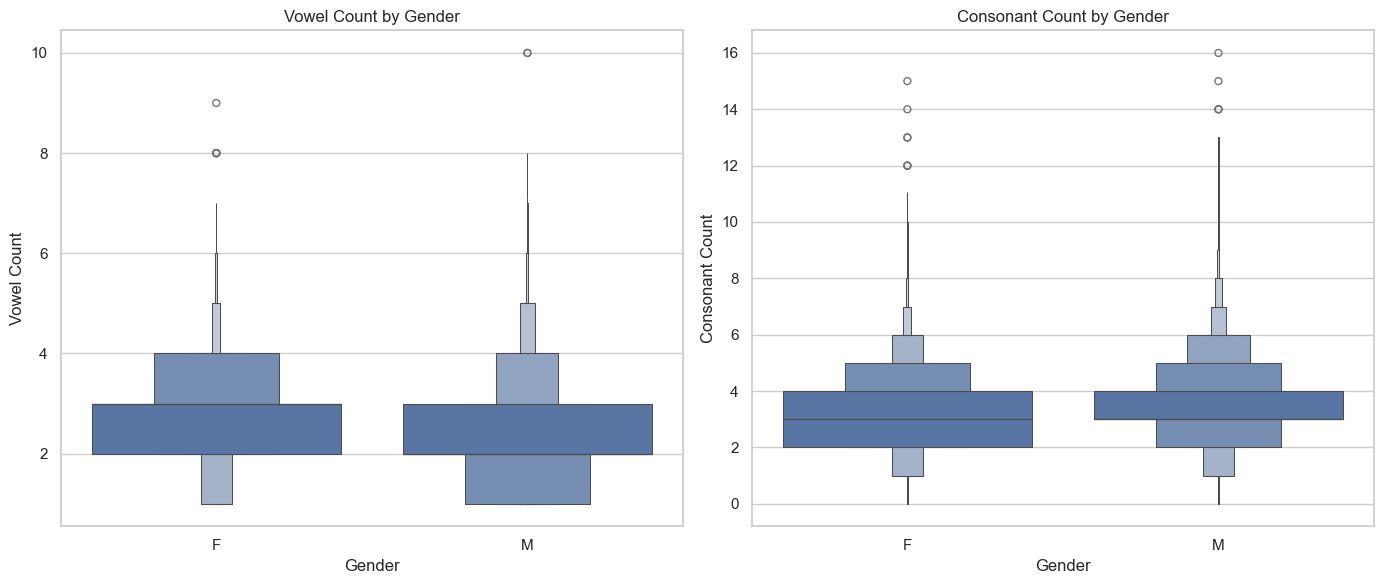

In [348]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for vowel count by sex
sns.boxenplot(data=df_char_cleaned, x='Sex', y='vowel_count', ax=axes[0])
axes[0].set_title('Vowel Count by Gender')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Vowel Count')

# Boxplot for consonant count by sex
sns.boxenplot(data=df_char_cleaned, x='Sex', y='consonant_count', ax=axes[1])
axes[1].set_title('Consonant Count by Gender')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Consonant Count')

plt.tight_layout()

### 2.2.b Name Length per gender

### 2.2.c First and last letters of the characters' name depending on the gender

*Interactive hover plot in this section*

#### 2.2.d Top names of characters across Age and Gender

*Interactive hover plot in this section*

In [349]:
analyze_gender.plot_age_sex_distribution_with_top_names()

## 2.3 Geographical Analysis

The aim of this section is to present the distribution of top character names across continents and countries.

### 2.3.a Continent Analysis

In [350]:
# Let's generate a table containing the most recurrent names for each continent
analyze_countries = CountryAnalyzer(df_char_cleaned)
df_continent = analyze_countries.create_continent_df()
df_continent.head()

,Continent,Female_name,Male_name
0,Africa,Amina*,Omar*
1,Asia,Priya,Vijay
2,Europe,La,John
3,North America,Sarah,John
4,Oceania,Angie,John


\* 3 other names are in a tie for this category. We choose to display only one name for readability

In the table above we see the most recurrent character names for each continent. For Asia, we see that the most common names are indian names. Is it because other nearby countries are influenced by the bollywood industry or because India's movies are predominent in this dataset? 
We will try to answer the question by plotting the most common character names per country and reting it with the number of movies from this country in the dataset.

### 2.3.b Country Analysis (Interractive World map)

*Interactive hover plot in this section*

In [351]:
df_top_names = analyze_countries.create_top_names_df()
analyze_countries.add_movie_count(df_top_names)
df_top_names = analyze_countries.cleaning_non_countries(df_top_names)

In [352]:
fig = go.Figure(go.Scattergeo(
))
fig.add_trace(go.Choropleth(
    locations= df_top_names['primary_country'],
    locationmode='country names',
    showscale= True,
    colorscale='YlOrRd',
    z=np.log10(df_top_names['Number_of_movies']),
    colorbar=dict(title="Number of movies (Log Scale)", tickvals=np.arange(0, 5), ticktext=[f"10^{i}" for i in range(0, 5)]),
    text= [f"Top female name: {female}<br>Top male name: {male}<br>Nb Movies: {movies:,}" 
           for female, male, movies in zip(df_top_names['Female_name'], df_top_names['Male_name'], df_top_names['Number_of_movies'])],
    hovertemplate="%{location}<br>%{text}"
))
fig.update_geos(
    projection_scale=1,center={'lat': 30},
    visible=False,
    showcountries=True, countrycolor="RebeccaPurple"
)
fig.update_layout(
    geo=dict(
        projection_type="mercator",
        lakecolor="aqua"
    ),
    height=500,
    margin={"r":0,"t":5,"l":0,"b":0},
    title_text="Most Common Male and Female Character Names by Country",
    title_x=0.4,
    title_y=0.90
)
fig.show()

### 2.3.c Statistical analysis (Geography)

We are going to run a chi2 test in order to verify that there is noticeable correlation between geography and characters' names

In [353]:
# Chi2 test
contingency_table = create_contingency_table(df_char_cleaned,'Character_name','primary_country')
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"p-value: {p_value}")

Chi-Square Statistic: 7796708.1732684765
p-value: 0.0


Looking the results above, we see that we have a p-value equal to 0, meaning that there is a statistically significant association between the country of movie production and the character names in the movie. We will now investigate the strength of this association using Cramér's V.

In [354]:
n = contingency_table.sum().sum()
k = min(contingency_table.shape)
cramers_v = np.sqrt(chi2 / (n * (k - 1)))

print(f"Cramér's V: {cramers_v}")

Cramér's V: 0.6900272760393569


The Cramér's V is superior to 0.5 meaning that there is a strong association between the country of production of the movie and the name of the characters in the movies.

## Phonetics

In [355]:
# We will divide consonants by their manner of articulation
plosive = ['P','T','B','K']
fricative = ['F','X','0','S','H']
affricate = ['J']
nasal =['M','N']
liquid = ['L','R']
manner_groups = [plosive,fricative,affricate,nasal,liquid]
manner_names = ['plosive','fricative','affricate','nasal','liquid']


In [356]:
analyze_phonetics = PhoneticAnalyzer(df_char_cleaned,manner_groups,manner_names)


### Gender

In [357]:
manner_df = analyze_phonetics.phonetics_by_gender()

/Users/luca/Desktop/ada-2024-project-adadasurmonbidet2024/src/utils/results_utils.py:528: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [401]:
fig = go.Figure()

# Get unique sexes and loop through them
sexes = manner_df['Sex'].unique()

color_map ={
    'M':'#87CEEB', 
    'F':'#FA8072'
}
for sex in sexes:
    filtered_df = manner_df[manner_df['Sex'] == sex]
    fig.add_trace(go.Bar(
        x=filtered_df['Consonant_Group'],
        y=filtered_df['Percent'],
        name=sex,
        marker_color=color_map[sex]
    ))

# Customize layout for grouped bars
fig.update_layout(
    title='Distribution of Phonetic Names by Consonant Groups and Sex',
    xaxis_title='Consonant Groups',
    yaxis_title='Percentage',
    barmode='group',  # This ensures bars are grouped side by side
    legend_title='Sex',
    template='plotly_white'
)

# Display the plot
fig.show()

The plot above show that plosives, fricatives and affricates sounds are more common in male character names while nasal and liquid names are more common for female character names. Although not formally defined on a linguistic point of view, we can regroup plosives, fricatives and affricates sounds as 'hard' sounds and nasal and liquid sounds as 'soft' sounds. From this we can deduce that male names are more likely to contain 'hard' sounds and female names 'soft' sounds. 

### Age

In [359]:
manner_age_df = analyze_phonetics.phonetics_by_age()


In [360]:
#let's place the age groups in the correct order

age_order = ['<12y','13y-17y','18y-24y','25y-34y','35y-44y','45y-54y','55y-64y','65y-74y','75y-84y','>85y']
manner_age_df['age_category'] = pd.Categorical(
    manner_age_df['age_category'],
    categories=age_order,
    ordered=True
)

In [361]:
manner_age_df.head()

,Consonant_Group,age_category,Count,Percent
0,affricate,13y-17y,351,11.959114
1,affricate,18y-24y,1496,11.955566
2,affricate,25y-34y,4175,12.059852
3,affricate,35y-44y,3405,11.687376
4,affricate,45y-54y,2129,11.549938


In [410]:
custom_colors = {
    'affricate': '#386641',
    'fricative': '#6a994e',
    'liquid': '#a7c957',
    'nasal': '#f2e8cf',
    'plosive': '#bc4749'
}

fig = px.line(
    manner_age_df,
    x='age_category',
    y='Percent',
    color='Consonant_Group',
    markers=True,  # Adds markers to the line
    color_discrete_map=custom_colors
)

# Customize layout
fig.update_layout(
    title='Percentage of Names Containing Each Consonant Group Across Age Categories',
    xaxis_title='Age Category',
    yaxis_title='Percentage',
    legend_title='Consonant Group',
    template='plotly_white'
)

# Display the plot
fig.show()

# 3 Sentimental Analysis

This section marks the beginning of the sentiment analysis, focusing particularly on the preprocessing of the movies synopsies dataset. For each character in every movie, the goal was to identify the sentences involving them directly in the summaries using natural language processing (NLP).

To run this part, you will need to download the “corenlp_plot_summaries” locally, as we couldn't import it in the repository. You can find the result of our prepropccessing as "sentences_by_characters.csv" in the "data" folder. 

**P3 :**  Find a solution to import the "corenlp_plot_summaries" file directly on the github repository.

In [363]:

df = pd.read_csv('data/sentences_by_character.csv')
print(df.shape)

(55863, 4)


In [364]:
df_sentiment_analysis_textblob = pd.read_csv('data/sentimental_analysis.csv')
df_sentiment_analysis_textblob.head()

,Character_Name,Wikipedia_id,Polarity,Subjectivity
0,Williams,3217,0.196667,0.450000
1,Sheila,3217,0.042172,0.308838
2,Arthur,3217,0.040338,0.295411
3,Ash,3217,0.040338,0.295411
4,Duke,3217,0.044180,0.323545


## Interpretation of the results

TextBlob uses two key metrics for sentiment analysis: Polarity and Subjectivity.

- **Polarity (P):** Measures sentiment on a scale from **-1** (most negative) to **1** (most positive).
- **Subjectivity (S):** Measures how subjective or objective the sentiment is, ranging from **0** (most objective) to **1** (most subjective).


| Polarity (P)    | Subjectivity (S) | Interpretation                |
|---------------------|------------------------|------------------------------------|
| [-1; -0.5]      | [0.5; 1]           | Very Negative & Subjective        |
| [-0.5; 0]       | [0; 0.5]           | Negative but Fairly Objective     |
| 0               | [0; 1]             | Neutral                           |
| [0; 0.5]        | [0; 0.5]           | Positive but Fairly Objective     |
| [0.5; 1]        | [0.5; 1]           | Very Positive & Subjective        |


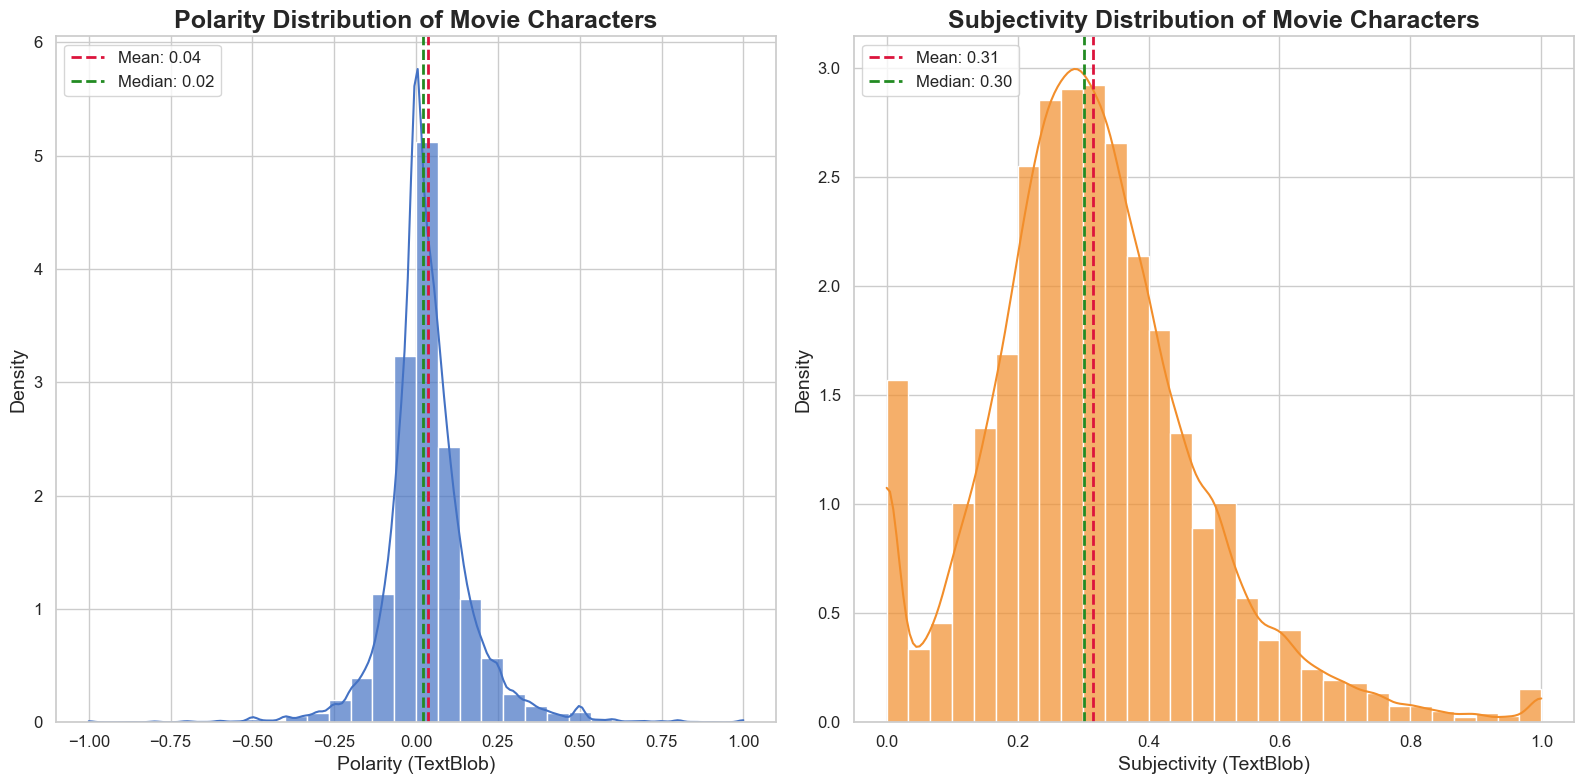

In [365]:
sns.set_theme(style="whitegrid")

# Create the figure
plt.figure(figsize=(16, 8))

# Polarity Distribution Plot
plt.subplot(1, 2, 1)
sns.histplot(
    df_sentiment_analysis_textblob['Polarity'], 
    kde=True, color='#4472C4', bins=30, stat='density', alpha=0.7
)
mean_pol = df_sentiment_analysis_textblob['Polarity'].mean()
median_pol = df_sentiment_analysis_textblob['Polarity'].median()

# Add statistical annotations
plt.axvline(mean_pol, color='crimson', linestyle='--', linewidth=2, label=f'Mean: {mean_pol:.2f}')
plt.axvline(median_pol, color='forestgreen', linestyle='--', linewidth=2, label=f'Median: {median_pol:.2f}')
plt.title('Polarity Distribution of Movie Characters', fontsize=18, weight='bold')
plt.xlabel('Polarity (TextBlob)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')

# Subjectivity Distribution Plot
plt.subplot(1, 2, 2)
sns.histplot(
    df_sentiment_analysis_textblob['Subjectivity'], 
    kde=True, color='#F28E2B', bins=30, stat='density', alpha=0.7
)
mean_sub = df_sentiment_analysis_textblob['Subjectivity'].mean()
median_sub = df_sentiment_analysis_textblob['Subjectivity'].median()

# Add statistical annotations
plt.axvline(mean_sub, color='crimson', linestyle='--', linewidth=2, label=f'Mean: {mean_sub:.2f}')
plt.axvline(median_sub, color='forestgreen', linestyle='--', linewidth=2, label=f'Median: {median_sub:.2f}')
plt.title('Subjectivity Distribution of Movie Characters', fontsize=18, weight='bold')
plt.xlabel('Subjectivity (TextBlob)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')

# Adjust layout and show
plt.tight_layout()
plt.show()

In [366]:
from scipy.stats import pearsonr, shapiro

# Calcul du coefficient de corrélation de Pearson
correlation, _ = pearsonr(df_sentiment_analysis_textblob["Polarity"], df_sentiment_analysis_textblob["Subjectivity"])
print(f"Pearson Correlation: {correlation:.2f}")

Pearson Correlation: 0.19


The weak **Pearson correlation** of 0.19 between polarity and subjectivity indicates that these two variables are not strongly related. While there may be some minor associations, they largely function independently. Given this independence, we will now primarily focus on polarity in our analysis as follow:

| Polarity (P)    | Interpretation                |
|---------------------|------------------------|
| [-1; -0.5]      | Very bad guy: You arch-nemesis, you'd rather fight a bear than run into him/her !        |
| [-0.5; 0]       | Bad guy: That person you politely tolerate, but "let's not get too close".     |
| 0               | Neutral, that random person in the elevator you nod at.                          |
| [0; 0.5]        | Nice guy: Your chill buddy you'd grab coffee with :)      |
| [0.5; 1]        | Very nice guy: Your ultimate-ride-or-die BFF, partner in crime !        |

In [367]:
df_sentiment_analysis_textblob['Interpretation_SA'] = df_sentiment_analysis_textblob['Polarity'].apply(interpret_polarity)
df_sentiment_analysis_textblob.head()

,Character_Name,Wikipedia_id,Polarity,Subjectivity,Interpretation_SA
0,Williams,3217,0.196667,0.450000,Nice guy
1,Sheila,3217,0.042172,0.308838,Nice guy
2,Arthur,3217,0.040338,0.295411,Nice guy
3,Ash,3217,0.040338,0.295411,Nice guy
4,Duke,3217,0.044180,0.323545,Nice guy


## Good Guy/ Bad Guy distribution

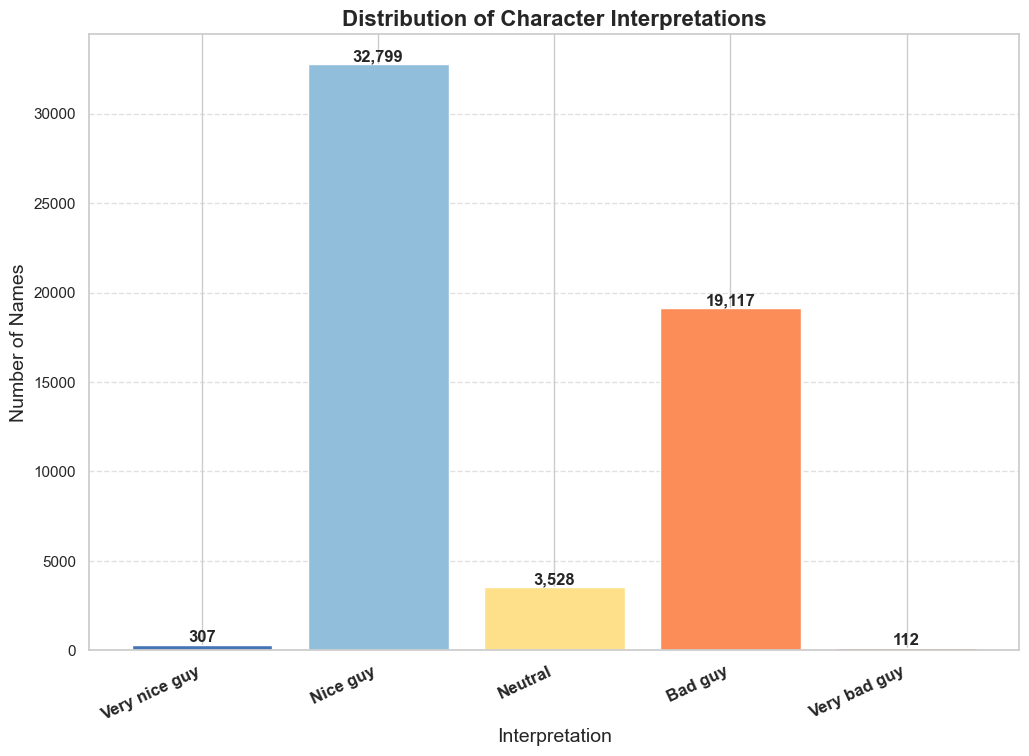

In [368]:
# Define the desired order of categories
desired_order = ["Very nice guy", "Nice guy", "Neutral", "Bad guy", "Very bad guy"]

# Count interpretations and reorder
interpretation_counts = df_sentiment_analysis_textblob['Interpretation_SA'].value_counts()

# Reindex interpretation_counts to match the desired order
interpretation_counts = interpretation_counts.reindex(desired_order)

# Create a prettier plot
plt.figure(figsize=(12, 8))
bars = plt.bar(
    interpretation_counts.index, 
    interpretation_counts.values, 
    color=['#4575b4', '#91bfdb', '#fee08b', '#fc8d59', '#d73027']  # Colors reordered for consistency
)

# Add annotations
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:,}', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Customize appearance
plt.title('Distribution of Character Interpretations', fontsize=16, fontweight='bold')
plt.xlabel('Interpretation', fontsize=14)
plt.ylabel('Number of Names', fontsize=14)
plt.xticks(rotation=25, ha='right', fontsize=12, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

## Addition of the sentimental analysis to the original cleaned dataset

In [369]:
df_char_cleaned_SA.rename(columns={'Character_name': 'Character_Name', 'Wikipedia_ID': 'Wikipedia_id'}, inplace=True)
df_merged = pd.merge(df_char_cleaned_SA, df_sentiment_analysis_textblob, left_on=['Wikipedia_id', 'Character_Name'], right_on=['Wikipedia_id', 'Character_Name'], how='inner')
df_merged.drop('Subjectivity', axis=1, inplace=True)
df_merged.head()

,Wikipedia_id,Name,Languages,Country,Character_Name,Sex,Actor_age,Release_date,Genre_Category,Polarity,Interpretation_SA
0,975900,Ghosts of Mars,[English Language],[United States of America],Melanie,F,27.0,2001-08-24,"['Action & Adventure', 'Horror & Thriller', 'F...",-0.021759,Bad guy
1,975900,Ghosts of Mars,[English Language],[United States of America],Williams,M,32.0,2001-08-24,"['Action & Adventure', 'Horror & Thriller', 'F...",-0.021759,Bad guy
2,975900,Ghosts of Mars,[English Language],[United States of America],Jericho,M,33.0,2001-08-24,"['Action & Adventure', 'Horror & Thriller', 'F...",-0.021759,Bad guy
3,975900,Ghosts of Mars,[English Language],[United States of America],Helena,F,52.0,2001-08-24,"['Action & Adventure', 'Horror & Thriller', 'F...",-0.096875,Bad guy
4,975900,Ghosts of Mars,[English Language],[United States of America],Mars,M,NaN,2001-08-24,"['Action & Adventure', 'Horror & Thriller', 'F...",0.041667,Nice guy


## Kindness Analysis

In [370]:
df_SA_analysis = df_merged.copy()
df_SA_analysis['kindness'] = df_merged['Polarity'].apply(good_guy_detector)
df_SA_analysis = df_SA_analysis[df_SA_analysis['kindness'] != 'Not significant']
#df_SA_analysis.head(50)
df_sorted = df_SA_analysis[df_SA_analysis['Sex']=='F'].sort_values(by='Polarity', ascending=False)
df_sorted.head(5)

,Wikipedia_id,Name,Languages,Country,Character_Name,Sex,Actor_age,Release_date,Genre_Category,Polarity,Interpretation_SA,kindness
56344,9825500,Fifty Pills,[English Language],[United States of America],Gracie,F,26.0,2007,"['Comedy', 'Cult & B-Movies']",1.0,Very nice guy,1
45165,24436496,Equinox,[English Language],[United States of America],Beverly,F,22.0,1992-09-18,"['Drama', 'Cult & B-Movies']",1.0,Very nice guy,1
18369,19136103,The Cold Room,"[German Language, English Language]",[United Kingdom],Sophie,F,NaN,1984-03-24,"['Action & Adventure', 'Horror & Thriller', 'F...",1.0,Very nice guy,1
47424,11063492,Saving Shiloh,[English Language],[United States of America],Samantha,F,12.0,2006-05-12,['Drama'],1.0,Very nice guy,1
35806,15513119,Who Loves the Sun,[English Language],[Canada],Maggie,F,33.0,2006-06-06,"['Romance', 'Drama', 'Cult & B-Movies', 'Comedy']",1.0,Very nice guy,1


In [371]:
df_SA_analysis = df_SA_analysis.rename(columns={'Character_Name': 'Character_name'})
analyze_SA = GoodBadGuyAnalyzer(df_SA_analysis)

bad_guys_names, bad_girls_names = analyze_SA.get_bad_guys_girls_names_SA(8)
good_guys_names, good_girls_names = analyze_SA.get_good_guys_girls_names_SA(8)

data_f_bad = analyze_SA.create_sunburst_data_SA(bad_girls_names)
data_f_good = analyze_SA.create_sunburst_data_SA(good_girls_names)

data_m_bad = analyze_SA.create_sunburst_data_SA(bad_guys_names)
data_m_good = analyze_SA.create_sunburst_data_SA(good_guys_names)

In [372]:
# Create the sunburst plots for females and males
fig_bad_girls = go.Figure(go.Sunburst(
    labels=data_f_bad['character'],
    parents=data_f_bad['parent'],
    domain=dict(column=1),
    maxdepth=2
))

fig_good_girls = go.Figure(go.Sunburst(
    labels=data_f_good['character'],
    parents=data_f_good['parent'],
    domain=dict(column=1),
    maxdepth=2
))

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["BAD GIRLS", "GOOD GIRLS"],
    specs=[[{"type": "sunburst"}, {"type": "sunburst"}]]
)

fig.add_trace(fig_good_girls['data'][0], row=1, col=1)
fig.add_trace(fig_bad_girls['data'][0], row=1, col=2)

fig.update_layout(
    title_text="Good Girls VS Bad Girls Names by Genre",
    showlegend=False,
    width=1600,
    height=800,
    font=dict(size=13),
)

fig.show()

In [373]:
# from textblob import TextBlob

# def get_sentiment_with_textblob(sentence):
#     analysis = TextBlob(sentence)
#     return analysis.sentiment.polarity, analysis.sentiment.subjectivity

# def process_character_sentiments_textblob(sentences):
#     polarity_textblob = []
#     subjectivity_textblob = []
    
#     for sentence in sentences:
#         polarity, subjectivity = get_sentiment_with_textblob(sentence)
#         polarity_textblob.append(polarity)
#         subjectivity_textblob.append(subjectivity)
    
#     mean_polarity_textblob = np.mean(polarity_textblob) if polarity_textblob else None
#     mean_subjectivity_textblob = np.mean(subjectivity_textblob) if subjectivity_textblob else None

#     return mean_polarity_textblob, mean_subjectivity_textblob


In [374]:
# Create the sunburst plots for females and males
fig_bad_guys = go.Figure(go.Sunburst(
    labels=data_m_bad['character'],
    parents=data_m_bad['parent'],
    domain=dict(column=1),
    maxdepth=2
))

fig_good_guys = go.Figure(go.Sunburst(
    labels=data_m_good['character'],
    parents=data_m_good['parent'],
    domain=dict(column=1),
    maxdepth=2
))

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["BAD GUYS", "GOOD GUYS"],
    specs=[[{"type": "sunburst"}, {"type": "sunburst"}]]
)

fig.add_trace(fig_good_guys['data'][0], row=1, col=1)
fig.add_trace(fig_bad_guys['data'][0], row=1, col=2)

fig.update_layout(
    title_text="Good Guys VS Bad Guys Names by Genre",
    showlegend=False,
    width=1600,
    height=800,
    font=dict(size=13),
)

fig.show()

---

## Russia vs USA

In [375]:
df_ethnicity = pd.read_csv('data/movie_character_ethnicity.csv')
df_ethnicity.head()

,Name,Ethnicity
0,Akooshay,Germanic
1,Melanie,English-Speaking
2,Williams,Southern and Western Slavic
3,Jericho,English-Speaking
4,Bashira,Germanic


In [376]:
# Merge ethnicity dataset with sentimental analysis dataset

df_ethn_SA = pd.merge(df_merged, df_ethnicity, left_on='Character_Name', right_on='Name', how='inner')
df_ethn_SA.head()

,Wikipedia_id,Name_x,Languages,Country,Character_Name,Sex,Actor_age,Release_date,Genre_Category,Polarity,Interpretation_SA,Name_y,Ethnicity
0,975900,Ghosts of Mars,[English Language],[United States of America],Melanie,F,27.0,2001-08-24,"['Action & Adventure', 'Horror & Thriller', 'F...",-0.021759,Bad guy,Melanie,English-Speaking
1,975900,Ghosts of Mars,[English Language],[United States of America],Williams,M,32.0,2001-08-24,"['Action & Adventure', 'Horror & Thriller', 'F...",-0.021759,Bad guy,Williams,Southern and Western Slavic
2,975900,Ghosts of Mars,[English Language],[United States of America],Jericho,M,33.0,2001-08-24,"['Action & Adventure', 'Horror & Thriller', 'F...",-0.021759,Bad guy,Jericho,English-Speaking
3,975900,Ghosts of Mars,[English Language],[United States of America],Helena,F,52.0,2001-08-24,"['Action & Adventure', 'Horror & Thriller', 'F...",-0.096875,Bad guy,Helena,Germanic
4,975900,Ghosts of Mars,[English Language],[United States of America],Mars,M,NaN,2001-08-24,"['Action & Adventure', 'Horror & Thriller', 'F...",0.041667,Nice guy,Mars,English-Speaking


In [377]:
df_ethn_SA_dates = df_ethn_SA.drop(columns=['Wikipedia_id','Name_x','Languages','Sex',
                         'Actor_age','Genre_Category','Polarity','Name_y'])

df_ethn_SA.drop(columns=['Wikipedia_id','Name_x','Languages','Sex',
                         'Actor_age','Release_date','Genre_Category','Polarity','Name_y'], inplace=True)
df_ethn_SA.head()

,Country,Character_Name,Interpretation_SA,Ethnicity
0,[United States of America],Melanie,Bad guy,English-Speaking
1,[United States of America],Williams,Bad guy,Southern and Western Slavic
2,[United States of America],Jericho,Bad guy,English-Speaking
3,[United States of America],Helena,Bad guy,Germanic
4,[United States of America],Mars,Nice guy,English-Speaking


In [378]:
df_ethn_SA['Country'] = df_ethn_SA['Country'].str[0]

In [379]:
#Filtering dataframe to only movies from Russia and USA

df_usa = df_ethn_SA[df_ethn_SA['Country']=='United States of America']
df_rus = df_ethn_SA[df_ethn_SA['Country']=='Russia']

In [380]:
df_rus.head()

,Country,Character_Name,Interpretation_SA,Ethnicity
1280,Russia,Karl,Nice guy,Romance
1731,Russia,Jesus,Nice guy,Southern and Western Slavic
1732,Russia,Rachel,Nice guy,Romance
1733,Russia,Magdalene,Bad guy,English-Speaking
1734,Russia,Jairus,Nice guy,English-Speaking


In [381]:
df_usa['Count']=1
df_usa1 = df_usa.groupby(['Interpretation_SA', 'Ethnicity'])['Count'].sum().reset_index()

#We drop rows with really small counts
df_usa1 = df_usa1.loc[df_usa1['Ethnicity']!='Nordic'].copy()
df_usa1 = df_usa1.loc[df_usa1['Ethnicity']!='Hispanic'].copy()
df_usa1 = df_usa1.loc[df_usa1['Ethnicity']!='East Asian'].copy()
df_usa1['Proportion'] = df_usa1.groupby('Interpretation_SA')['Count'].transform(lambda x: x / x.sum())*100

#We only want the bad guys
df_usa1 = df_usa1.loc[df_usa1['Interpretation_SA']=='Bad guy'].copy()
df_usa1.head(12)

/var/folders/5n/10j2bk_d6_5d_78gychkbs6m0000gn/T/ipykernel_23140/3471601852.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Interpretation_SA,Ethnicity,Count,Proportion
1,Bad guy,Eastern Slavic,264,1.882085
2,Bad guy,English-Speaking,8280,59.029015
3,Bad guy,Germanic,3185,22.706209
6,Bad guy,Romance,1429,10.187496
7,Bad guy,Southern and Western Slavic,869,6.195195


In [382]:
df_rus['Count']=1
df_rus1 = df_rus.groupby(['Interpretation_SA', 'Ethnicity'])['Count'].sum().reset_index()

#We add rows for each of themissing ethnicities
added_rows =pd.DataFrame({'Interpretation_SA': ['Bad guy'],
               'Ethnicity': ['Romance'], 
               'Count': [0]})
df_rus1 = pd.concat([df_rus1, added_rows], ignore_index=True)

df_rus1['Proportion'] = df_rus1.groupby('Interpretation_SA')['Count'].transform(lambda x: x / x.sum())*100

#We only want the bad guys

df_rus1 = df_rus1.loc[df_rus1['Interpretation_SA']=='Bad guy'].copy()
#We sort to have same order as fro usa

df_rus1 = df_rus1.sort_values(by='Ethnicity',ascending=True)
df_rus1.head(20)

/var/folders/5n/10j2bk_d6_5d_78gychkbs6m0000gn/T/ipykernel_23140/1859100495.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Interpretation_SA,Ethnicity,Count,Proportion
0,Bad guy,Eastern Slavic,2,9.523810
1,Bad guy,English-Speaking,12,57.142857
2,Bad guy,Germanic,5,23.809524
11,Bad guy,Romance,0,0.000000
3,Bad guy,Southern and Western Slavic,2,9.523810


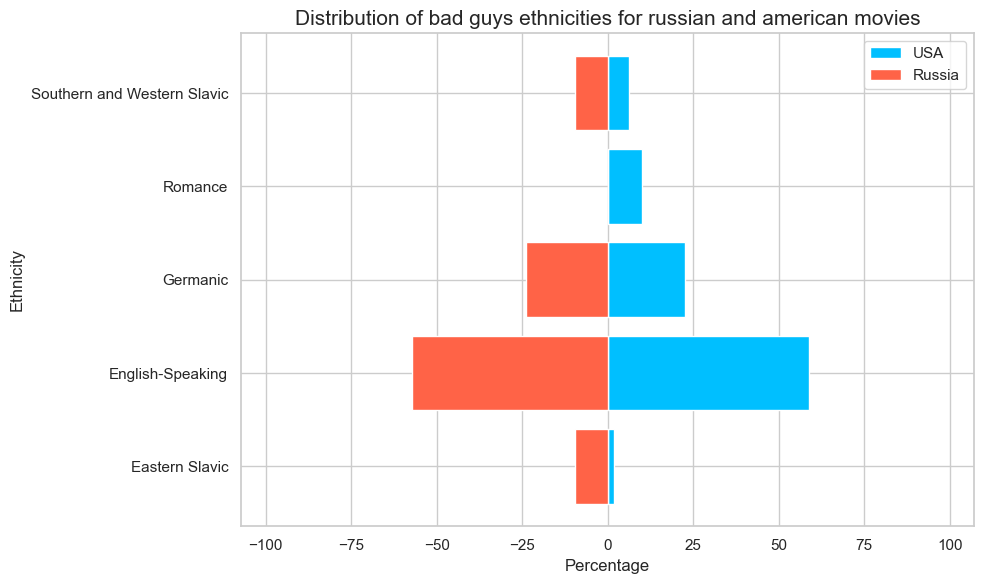

In [383]:
fig, ax = plt.subplots(figsize=(10, 6))

ethnicities = ['Eastern Slavic','English-Speaking','Germanic','Romance','Southern and Western Slavic']

# Bar plots for Male and Female
ax.barh(ethnicities, df_usa1['Proportion'], color='deepskyblue', label='USA')
ax.barh(ethnicities, -df_rus1['Proportion'], color='tomato', label='Russia')

# Labels and title
ax.set_xlabel('Percentage')
ax.set_ylabel('Ethnicity')
ax.set_title('Distribution of bad guys ethnicities for russian and american movies', fontsize=15)
ax.legend()

# Adjust x-axis for symmetry
max_population = max(df_rus1['Proportion'].max(), abs(df_usa1['Proportion'].min()))
ax.set_xlim(-max_population - 50, max_population + 50)

plt.tight_layout()
plt.show()

In [384]:
df_usa2 = df_usa.groupby(['Ethnicity','Interpretation_SA'])['Count'].sum().reset_index().copy()

#Remove Very nice and very bad guys since they are an extreme minority
df_usa2 = df_usa2.loc[df_usa2['Interpretation_SA']!='Very nice guy'].copy()
df_usa2 = df_usa2.loc[df_usa2['Interpretation_SA']!='Very bad guy'].copy()

df_usa2['Proportion'] = df_usa2.groupby('Ethnicity')['Count'].transform(lambda x: x / x.sum())*100
df_usa2.head(20)

,Ethnicity,Interpretation_SA,Count,Proportion
0,East Asian,Bad guy,34,27.200000
1,East Asian,Neutral,7,5.600000
2,East Asian,Nice guy,84,67.200000
3,Eastern Slavic,Bad guy,264,31.730769
4,Eastern Slavic,Neutral,45,5.408654
5,Eastern Slavic,Nice guy,523,62.860577
8,English-Speaking,Bad guy,8280,35.046136
9,English-Speaking,Neutral,1408,5.959536
10,English-Speaking,Nice guy,13938,58.994328
13,Germanic,Bad guy,3185,36.312849


In [385]:
def proportion_plot(df):   
    pivot_df = df.pivot_table(index='Ethnicity', columns='Interpretation_SA', values='Proportion')

    pivot_df = pivot_df.reset_index()

    long_df = pivot_df.reset_index().melt(id_vars='Ethnicity', value_vars=pivot_df.columns, 
                                        var_name='Interpretation_SA', value_name='Proportion')

    color_map = {
        'Bad guy': 'tomato',
        'Neutral': 'lightgray',
        'Nice guy': 'lightgreen'
    }


    # Plot 
    fig = px.bar(long_df, 
                x='Proportion',
                y='Ethnicity', 
                color='Interpretation_SA', 
                orientation='h', 
                title="Proportion of Bad, Neutral, and Nice by Ethnicity in american movies",
                labels={'Proportion': 'Proportion (%)', 'Ethnicity': 'Ethnicity'},
                barmode='stack', 
                hover_data=['Proportion'], 
                color_discrete_map=color_map
                )

    fig.update_layout(
        xaxis=dict(showgrid=False),  # Remove x-axis gridlines
        yaxis=dict(showgrid=False),
        plot_bgcolor='white',
        bargap=0.2
    )
    fig.show()

In [386]:
proportion_plot(df_usa2)

### Cold War

In [387]:
def get_year(date):
    str_year = str(date)[:4]
    year = int(str_year)
    return year

In [388]:
df_ethn_SA_dates.dropna(inplace=True)
df_ethn_SA_dates['Country'] = df_ethn_SA_dates['Country'].str[0]
df_ethn_SA_dates['Year'] = df_ethn_SA_dates['Release_date'].apply(get_year)
df_ethn_SA_dates.head()

,Country,Character_Name,Release_date,Interpretation_SA,Ethnicity,Year
0,United States of America,Melanie,2001-08-24,Bad guy,English-Speaking,2001
1,United States of America,Williams,2001-08-24,Bad guy,Southern and Western Slavic,2001
2,United States of America,Jericho,2001-08-24,Bad guy,English-Speaking,2001
3,United States of America,Helena,2001-08-24,Bad guy,Germanic,2001
4,United States of America,Mars,2001-08-24,Nice guy,English-Speaking,2001


In [389]:
# We filter american and russian movies
df_usa = df_ethn_SA_dates[df_ethn_SA_dates['Country']=='United States of America']
df_rus_cold = df_ethn_SA_dates[df_ethn_SA_dates['Country']=='Russia']

# We filter movies to get only the noe released during the cold war

df_usa_cold = df_usa.loc[(df_usa['Year']>1947) & (df_usa['Year']<1991)]
df_rus_cold = df_rus_cold.loc[(df_rus_cold['Year']>1947) & (df_rus_cold['Year']<1991)]
df_rus_cold.shape

(1, 6)

We only are left with 1 character for russian movies released during the cold war. :( Therfore we will only analyze american movies

In [390]:
df_usa_cold['Count']=1
df_usa_cold_plot = df_usa_cold.groupby(['Ethnicity','Interpretation_SA'])['Count'].sum().reset_index().copy()

#Remove Very nice and very bad guys since they are an extreme minority
df_usa_cold_plot = df_usa_cold_plot.loc[df_usa_cold_plot['Interpretation_SA']!='Very nice guy'].copy()
df_usa_cold_plot = df_usa_cold_plot.loc[df_usa_cold_plot['Interpretation_SA']!='Very bad guy'].copy()

df_usa_cold_plot['Proportion'] = df_usa_cold_plot.groupby('Ethnicity')['Count'].transform(lambda x: x / x.sum())*100

/var/folders/5n/10j2bk_d6_5d_78gychkbs6m0000gn/T/ipykernel_23140/535080010.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [391]:
proportion_plot(df_usa_cold_plot)

We don't see a big different with the precedent plot. The only difference is for Nordic ethnicity but it is due to an unsufficient number of datapoints for this class. Our theory that 'villains' in american movies released during the cold war tend to have slavic names is not confirmed. 

In [393]:
df_usa['Count']=1
df_usa_year = df_usa.loc[df_usa['Interpretation_SA']=='Bad guy'].copy()

#We regroup years into spans of 5 years to be sure to have enough data in each category
df_usa_year['Year_Category'] = (df_usa_year['Year'] // 5) * 5

#We remove movies before 1930 because we don't have enough data
df_usa_year = df_usa_year[df_usa_year['Year_Category']>=1930]

df_usa_year = df_usa_year.groupby(['Year_Category', 'Ethnicity'])['Count'].sum().reset_index()
df_usa_year.head(20)

/var/folders/5n/10j2bk_d6_5d_78gychkbs6m0000gn/T/ipykernel_23140/3753918766.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Year_Category,Ethnicity,Count
0,1930,Eastern Slavic,4
1,1930,English-Speaking,96
2,1930,Germanic,36
3,1930,Hispanic,1
4,1930,Romance,16
5,1930,Southern and Western Slavic,7
6,1935,Eastern Slavic,3
7,1935,English-Speaking,127
8,1935,Germanic,47
9,1935,Hispanic,1


In [394]:
pivot_df_year = df_usa_year.pivot_table(index='Year_Category', columns='Ethnicity', values='Count')
pivot_df_year=pivot_df_year.fillna(value=0).reset_index()
pivot_df_year.head()

Ethnicity,Year_Category,East Asian,Eastern Slavic,English-Speaking,Germanic,Hispanic,Nordic,Romance,Southern and Western Slavic
0,1930,0.0,4.0,96.0,36.0,1.0,0.0,16.0,7.0
1,1935,0.0,3.0,127.0,47.0,1.0,0.0,24.0,11.0
2,1940,1.0,4.0,113.0,58.0,2.0,0.0,21.0,12.0
3,1945,1.0,2.0,115.0,48.0,2.0,0.0,24.0,15.0
4,1950,0.0,3.0,140.0,68.0,1.0,0.0,39.0,17.0


In [395]:
fig = go.Figure()

# Add traces using a for loop
for column in pivot_df_year.columns[2:]:  # Skip the 'Year' column
    fig.add_trace(go.Scatter(
        x=pivot_df_year['Year_Category'], y=pivot_df_year[column],
        stackgroup='one', name=column
    ))

# Customize the layout
fig.update_layout(
    title='Evolution of villains` name ethnicity in american movies over the year ',
    xaxis_title='Year',
    yaxis_title='Number of villains across the dataset',
    legend_title='Name ethnicity',
    template='plotly',
    hovermode='x unified'
)

# Show the figure
fig.show()

### Pre processing pour Roberta

La fonction ci-dessous permet de réduire aléatoirement le nombre de phrases affiliées à un prénom. La valeur "MAX_SENTENCES" peut être fixée manuellement pour plus ou moins de précision. 

In [ ]:
# list_characters = df_sentences_by_names["Character_Name"]
# MAX_SENTENCES = 100  # À ajuster selon besoin

# df_reduced = []

# for idx, row in df_sentences_by_names.iterrows():
#     if row["Sentence_Count"] > MAX_SENTENCES:
#         reduced_sentences = pd.Series(row["Sentences"]).sample(MAX_SENTENCES, random_state=42).tolist()
#     else:
#         reduced_sentences = row["Sentences"]
    
#     df_reduced.append({
#         "Character_Name": row["Character_Name"],
#         "Sentences": reduced_sentences,
#         "Sentence_Count": len(reduced_sentences)
#     })

df_reduced = pd.DataFrame(df_reduced)

### Fonctions pour Hugging Face

In [ ]:
from transformers import pipeline
import torch

sentiment_pipeline = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)

df_reduced_2 = df_reduced.head(7)

df_HF = []

for index, row in df_reduced_2.iterrows():
    character_name = row['Character_Name']
    sentences = row['Sentences']

    emotion_labels = []
    emotion_scores = []
    
    results = sentiment_pipeline(sentences)

    for res in results:
        sorted_emotions = sorted(res, key=lambda x: x['score'], reverse=True)

        if sorted_emotions[0]['label'] == 'neutral' and len(sorted_emotions) > 1:
            best_emotion = sorted_emotions[1]
        else:
            best_emotion = sorted_emotions[0]
        
        emotion_labels.append(best_emotion['label'])
        emotion_scores.append(best_emotion['score'])
    
    mean_emotion_score = np.mean(emotion_scores) if emotion_scores else None
    most_common_emotion = max(set(emotion_labels), key=emotion_labels.count)
    
    df_HF.append({
        "Character_Name": character_name,
        "Emotion_Label": most_common_emotion,
        "Emotion_Score": mean_emotion_score
    })

df_HF = pd.DataFrame(df_HF)
print(df_HF)

/opt/anaconda3/envs/ada/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



  Character_Name Emotion_Label  Emotion_Score
0       Williams      approval       0.093403
1         Sheila      approval       0.167935
2         Arthur      approval       0.103182
3            Ash      approval       0.087676
4           Duke      approval       0.123284
5      Sebastian      approval       0.116608
6        Deckard      approval       0.077829


In [ ]:
from transformers import pipeline

sentiment_pipeline = pipeline('sentiment-analysis', model="roberta-goemotions", tokenizer="roberta-goemotions")

def get_emotions_batch(sentences):
    result = sentiment_pipeline(sentences, batch_size=8)  
    return result

df_HF = []

for index, row in df_reduced.iterrows():
    character_name = row['Character_Name']
    sentences = row['Sentences']
    
    batch_size = 8  
    emotion_labels = []
    emotion_scores = []

    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i+batch_size]
        
        emotions = get_emotions_batch(batch_sentences)
        
        for emotion in emotions:
            emotion_labels.append(emotion['label'])
            emotion_scores.append(emotion['score'])
    
    mean_emotion_score = np.mean(emotion_scores) if emotion_scores else None
    most_common_emotion = max(set(emotion_labels), key=emotion_labels.count)
    
    df_HF.append({
        "Character_Name": character_name,
        "Emotion_Label": most_common_emotion,
        "Emotion_Score": mean_emotion_score
    })

df_HF = pd.DataFrame(df_HF)
print(df_HF)

### Fonctions pour Roberta SA

In [ ]:
# from transformers import pipeline

# def get_sentiment_with_roberta(sentence):
#     sentiment_pipeline = pipeline('sentiment-analysis', model='roberta-large-mnli')
#     result = sentiment_pipeline(sentence)
#     return result[0]["score"]

# def process_character_sentiments_roberta(sentences):
#     sentences_roberta = []
    
#     for sentence in sentences:
#         sentiment_with_roberta = get_sentiment_with_roberta(sentence)
#         sentences_roberta.append(sentiment_with_roberta)
    
#     mean_sentiment_roberta = np.mean(sentences_roberta) if sentences_roberta else None
    
#     return mean_sentiment_roberta

In [ ]:
# data_roberta = []

# for index, character_name in enumerate(list_characters):
#     list_sentences_by_character = df_reduced["Sentences"].iloc[index]
    
#     mean_sentiment_roberta = process_character_sentiments_roberta(list_sentences_by_character)

#     data_roberta.append({
#         "Character_Name": character_name,
#         "Sentiment": mean_sentiment_roberta
#     })

# df_sentiment_analysis_roberta = pd.DataFrame(data_roberta)
# print(df_sentiment_analysis_roberta)

### Regrouper les phrases par prénoms

In [98]:
# # Rassemble les phrases par prénoms

# df = pd.DataFrame(data)
# df['Sentence_Count'] = df['Sentences'].apply(len)
# df = df[df['Sentences'].apply(lambda x: len(x) > 0)]

# grouped_sentences_by_names = {}

# for index, row in df.iterrows():
#     character_name = row['Character_Name']
#     sentences = row['Sentences']
    
#     if character_name in grouped_sentences_by_names:
#         grouped_sentences_by_names[character_name].extend(sentences)  
#     else:
#         grouped_sentences_by_names[character_name] = sentences 

# grouped_sentences_by_names_list = []

# for character_name, sentences in grouped_sentences_by_names.items():
#     grouped_sentences_by_names_list.append({
#         'Character_Name': character_name,
#         'Sentences': sentences,
#         'Sentence_Count': len(sentences)
#     })

# df_sentences_by_names = pd.DataFrame(grouped_sentences_by_names_list)
# print(df_sentences_by_names)